In [86]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [87]:
# Read the dataset
# Transform the excel file in csv file
df = pd.read_excel('energy_demand.xlsx')

csv_file_path = 'energy_demand.csv'

df.to_csv(csv_file_path, index = False)

print(df)

            Date  Hour    load          T
0     2012-01-01     0  2872.0  30.666667
1     2012-01-01     1  2698.0  32.000000
2     2012-01-01     2  2558.0  32.666667
3     2012-01-01     3  2444.0  30.000000
4     2012-01-01     4  2402.0  31.000000
...          ...   ...     ...        ...
26300 2014-12-31    20  4012.0  18.000000
26301 2014-12-31    21  3856.0  16.666667
26302 2014-12-31    22  3671.0  17.000000
26303 2014-12-31    23  3499.0  15.333333
26304 2014-12-31    24  3345.0  15.333333

[26305 rows x 4 columns]


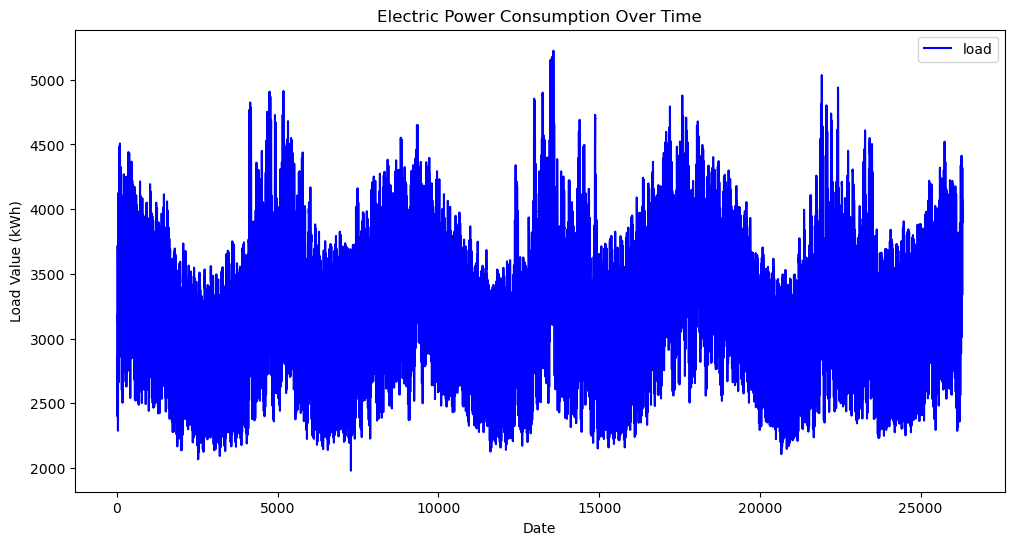

In [88]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Plot the time series of Load values
plt.figure(figsize=(12, 6))
plt.plot(df['load'], label='load', color='blue')
plt.title('Electric Power Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Load Value (kWh)')
plt.legend()
plt.show()

In [89]:
# Data Preparation

# Display columns names
print(df.columns)

# Change the column names
new_column_names = {
    'load' : 'Load Value',
    'T' : 'Temperature'
}

df.rename(columns = new_column_names, inplace = True)

print("Update columns : ")
print(df.columns)

Index(['Date', 'Hour', 'load', 'T'], dtype='object')
Update columns : 
Index(['Date', 'Hour', 'Load Value', 'Temperature'], dtype='object')


In [90]:
# Display basic information for dataset
print(df.info())

# Check data types
print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26305 entries, 0 to 26304
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         26305 non-null  datetime64[ns]
 1   Hour         26305 non-null  int64         
 2   Load Value   26305 non-null  float64       
 3   Temperature  26305 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 822.2 KB
None
Date           datetime64[ns]
Hour                    int64
Load Value            float64
Temperature           float64
dtype: object


In [91]:
# Display first few rows
print(df.head())

# Display last few rows
print(df.tail())

        Date  Hour  Load Value  Temperature
0 2012-01-01     0      2872.0    30.666667
1 2012-01-01     1      2698.0    32.000000
2 2012-01-01     2      2558.0    32.666667
3 2012-01-01     3      2444.0    30.000000
4 2012-01-01     4      2402.0    31.000000
            Date  Hour  Load Value  Temperature
26300 2014-12-31    20      4012.0    18.000000
26301 2014-12-31    21      3856.0    16.666667
26302 2014-12-31    22      3671.0    17.000000
26303 2014-12-31    23      3499.0    15.333333
26304 2014-12-31    24      3345.0    15.333333


In [92]:
# Display descriptive statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())
# Doesn't have missing values in the dataset

                                Date          Hour    Load Value   Temperature
count                          26305  26305.000000  26305.000000  26305.000000
mean   2013-07-01 11:30:01.710701312     12.499525   3303.752785     47.764988
min              2012-01-01 00:00:00      0.000000   1979.000000    -13.666667
25%              2012-09-30 00:00:00      6.000000   2867.000000     32.666667
50%              2013-07-01 00:00:00     12.000000   3364.000000     48.333333
75%              2014-04-01 00:00:00     18.000000   3690.000000     63.666667
max              2014-12-31 00:00:00     24.000000   5224.000000     95.000000
std                              NaN      6.922616    564.574798     19.338062
Date           0
Hour           0
Load Value     0
Temperature    0
dtype: int64


In [93]:
# Display unique values
for column in df.columns:
    # Print the column name and its unique values
    print(f"Unique values in {column}: {df[column].unique()}")

Unique values in Date: <DatetimeArray>
['2012-01-01 00:00:00', '2012-01-02 00:00:00', '2012-01-03 00:00:00',
 '2012-01-04 00:00:00', '2012-01-05 00:00:00', '2012-01-06 00:00:00',
 '2012-01-07 00:00:00', '2012-01-08 00:00:00', '2012-01-09 00:00:00',
 '2012-01-10 00:00:00',
 ...
 '2014-12-22 00:00:00', '2014-12-23 00:00:00', '2014-12-24 00:00:00',
 '2014-12-25 00:00:00', '2014-12-26 00:00:00', '2014-12-27 00:00:00',
 '2014-12-28 00:00:00', '2014-12-29 00:00:00', '2014-12-30 00:00:00',
 '2014-12-31 00:00:00']
Length: 1096, dtype: datetime64[ns]
Unique values in Hour: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Unique values in Load Value: [2872. 2698. 2558. ... 4449. 4360. 4319.]
Unique values in Temperature: [ 30.666667    32.          32.66666667  30.          31.
  31.33333333  29.          33.33333333  36.66666667  40.33333333
  43.66666667  43.33333333  45.          44.66666667  41.66666667
  41.33333333  42.66666667  44.33333333  44.          43.
  

In [94]:
# Check for duplicated values
print(df.duplicated().sum())
# We have 110 duplicated values

# Drop the duplicated values
df.drop_duplicates(inplace = True)
print(df.duplicated().sum())
# Already dropped

0
0


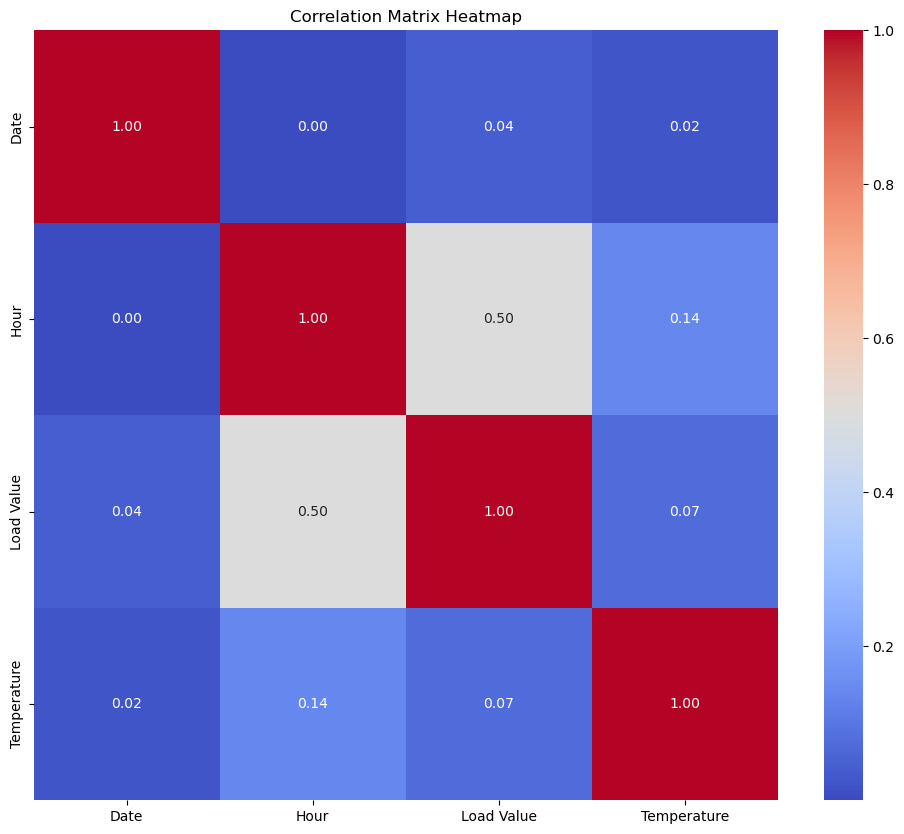

In [95]:
# Display correlation matrix
correlation_matrix = df.corr()

plt.figure(figsize = (12,10))

sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f")

plt.title('Correlation Matrix Heatmap')
plt.show()
# We can see we have an medium correlation beetween hour and Loan Value

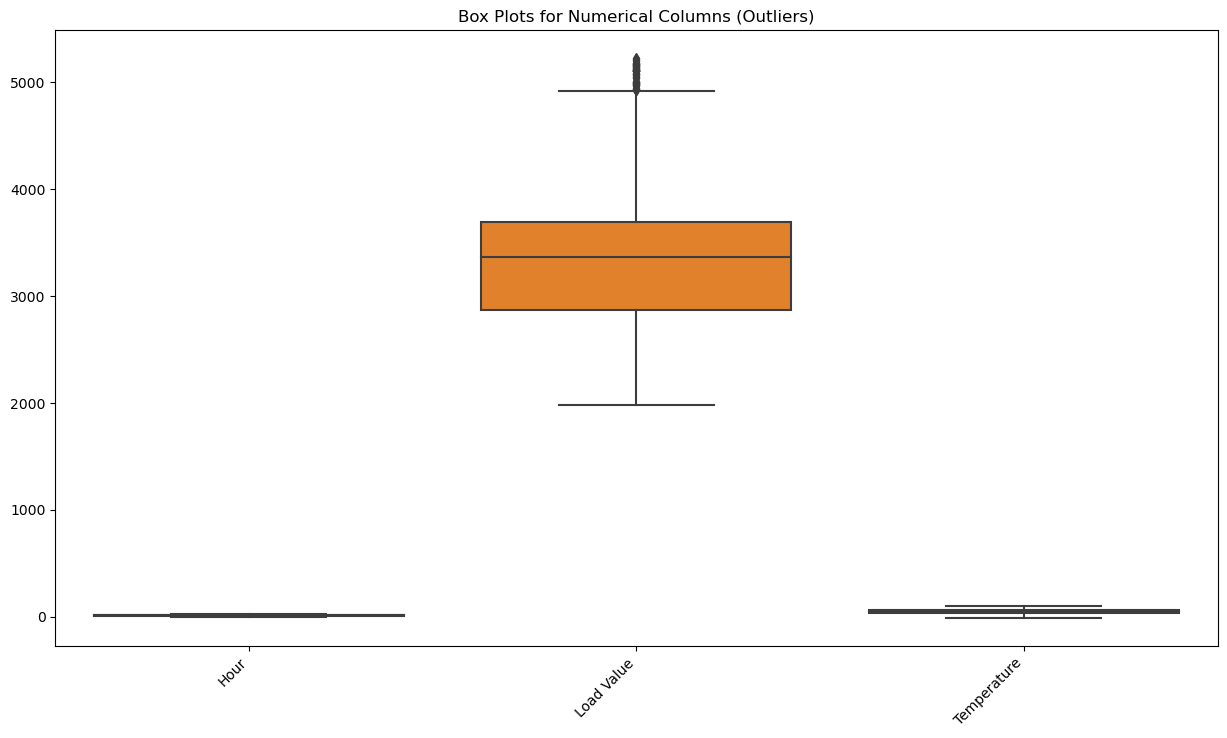

In [96]:
# Check for outliers in the dataset
numerical_columns = df.select_dtypes(include='number').columns

# Plot box plots for all numerical columns
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[numerical_columns])
plt.title('Box Plots for Numerical Columns (Outliers)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()
# Only have outliers in the Load Value column

In [97]:
# Check for anomalies
z_scores = zscore(df['Load Value'])
anomalies = (z_scores > 3) | (z_scores < -3)

# Display rows with anomalies
anomalies_df = df[anomalies]
print("Anomalies:")
print(anomalies_df)
print(anomalies_df.nunique())

Anomalies:
            Date  Hour  Load Value  Temperature
13476 2013-07-15    12      5007.0    86.000000
13477 2013-07-15    13      5040.0    88.000000
13478 2013-07-15    14      5088.0    89.333333
13479 2013-07-15    15      5112.0    90.333333
13480 2013-07-15    16      5132.0    91.000000
13481 2013-07-15    17      5151.0    91.666667
13482 2013-07-15    18      5152.0    91.333333
13483 2013-07-15    19      5113.0    89.666667
13500 2013-07-16    12      5053.0    86.666667
13501 2013-07-16    13      5103.0    88.333333
13502 2013-07-16    14      5147.0    88.666667
13503 2013-07-16    15      5124.0    87.666667
13504 2013-07-16    16      5104.0    88.000000
13505 2013-07-16    17      5110.0    90.000000
13506 2013-07-16    18      5098.0    89.666667
13507 2013-07-16    19      5042.0    87.000000
13525 2013-07-17    13      5076.0    86.333333
13526 2013-07-17    14      5133.0    88.666667
13527 2013-07-17    15      5166.0    89.000000
13528 2013-07-17    16      5

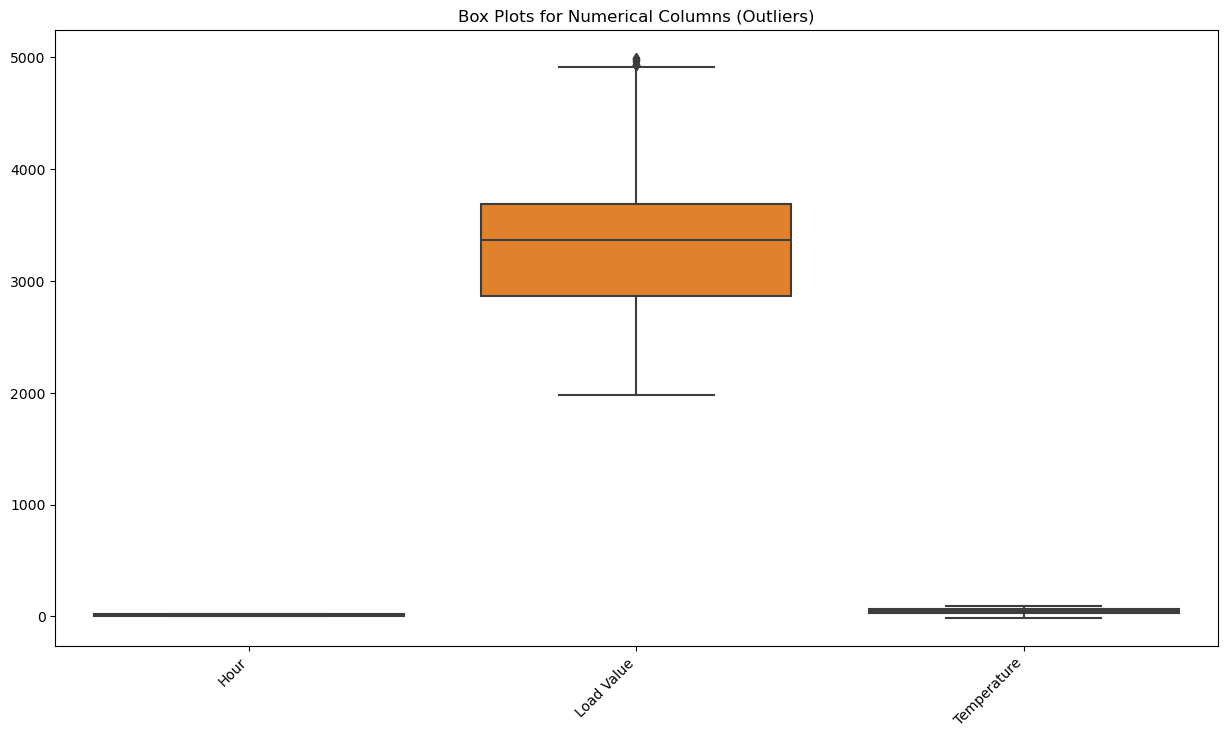

In [98]:
# Remove rows with anomalies
df_no_anomalies = df[~anomalies]
df = df_no_anomalies

# Check for outliers in the dataset
numerical_columns = df.select_dtypes(include='number').columns

# Plot box plots for all numerical columns
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[numerical_columns])
plt.title('Box Plots for Numerical Columns (Outliers)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

In [99]:
# Convert 'Hour' in a timedelta column
df['Hour'] = pd.to_timedelta(df['Hour'], unit='h')

# Create a new column 'DateTime' by combining 'Date' and 'Hour'
df['DateTime'] = df['Date'] + df['Hour']

# Drop the original 'Date' and 'Hour' columns if needed
df.drop(['Date', 'Hour'], axis=1, inplace=True)

print(df)

       Load Value  Temperature            DateTime
0          2872.0    30.666667 2012-01-01 00:00:00
1          2698.0    32.000000 2012-01-01 01:00:00
2          2558.0    32.666667 2012-01-01 02:00:00
3          2444.0    30.000000 2012-01-01 03:00:00
4          2402.0    31.000000 2012-01-01 04:00:00
...           ...          ...                 ...
26300      4012.0    18.000000 2014-12-31 20:00:00
26301      3856.0    16.666667 2014-12-31 21:00:00
26302      3671.0    17.000000 2014-12-31 22:00:00
26303      3499.0    15.333333 2014-12-31 23:00:00
26304      3345.0    15.333333 2015-01-01 00:00:00

[26266 rows x 3 columns]


In [ ]:
# Univariate Visualization